In [14]:
import torchvision
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.mobilenetv3 import MobileNet_V3_Large_Weights
import os
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights

#model = ssdlite320_mobilenet_v3_large(weights=None, num_classes=3,  weights_backbone=MobileNet_V3_Large_Weights.DEFAULT) # we do not specify pretrained=True, i.e. do not load default weights
#model.load_state_dict(torch.load(''))

num_classes = 3

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT)
    
# replace the classifier with a new one, that has
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


checkpoint = torch.load("Results/Models/FRCNN_opt_adam_epochs_40_train_backbone_False_lr_0.001_lrstepsize_8_lrgamma_0.1_mom_0.9_final.pth")
model.load_state_dict(checkpoint['model'])


# set the device (GPU is much faster)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
plt.plot(checkpoint["losses_train"], label="training loss")
plt.plot(checkpoint["losses_val"], label="validation loss")
plt.title(modelFile)
plt.legend()
plt.ylim((0, 0.3))
plt.show()

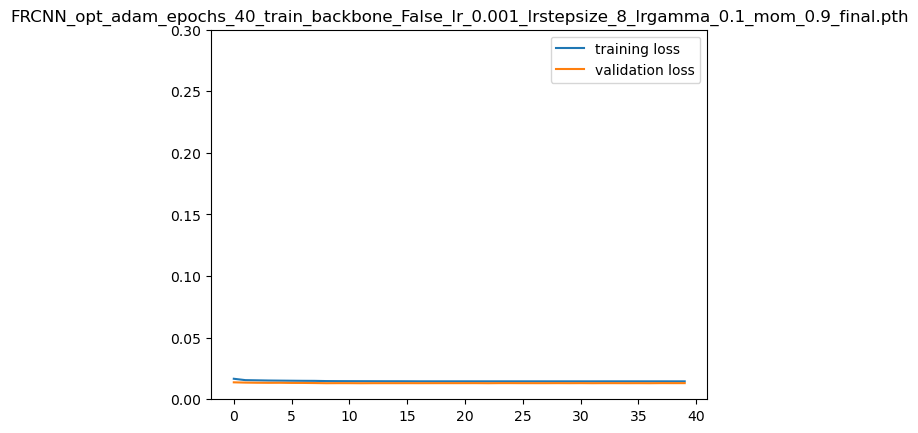

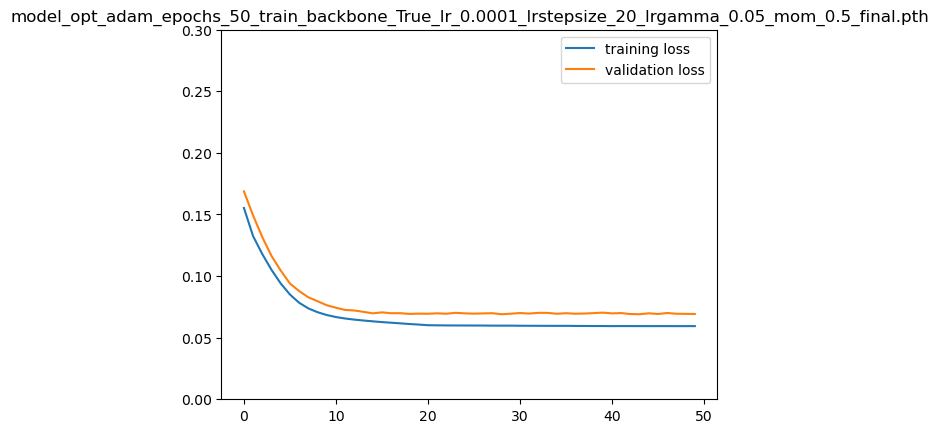

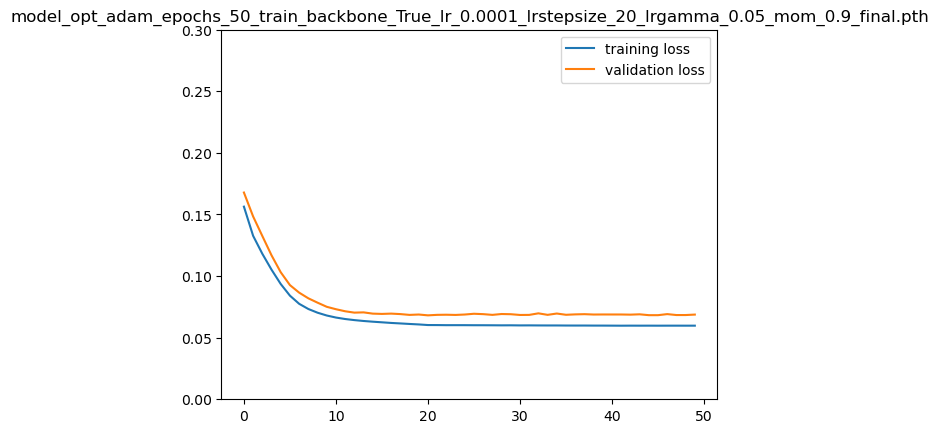

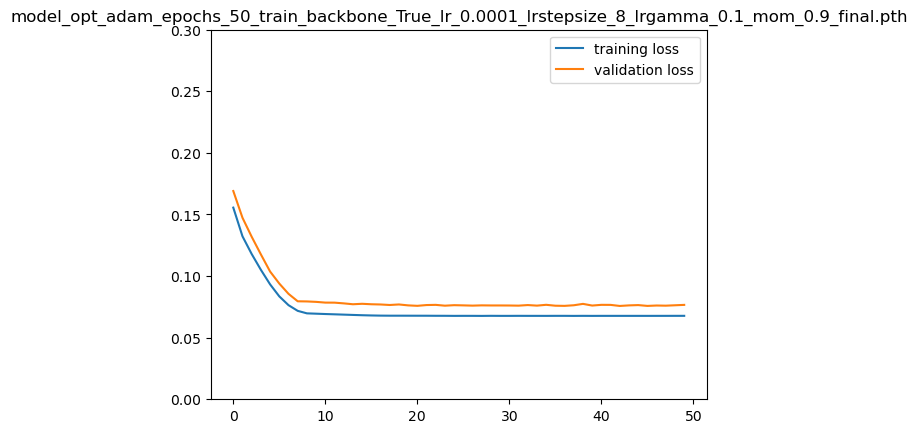

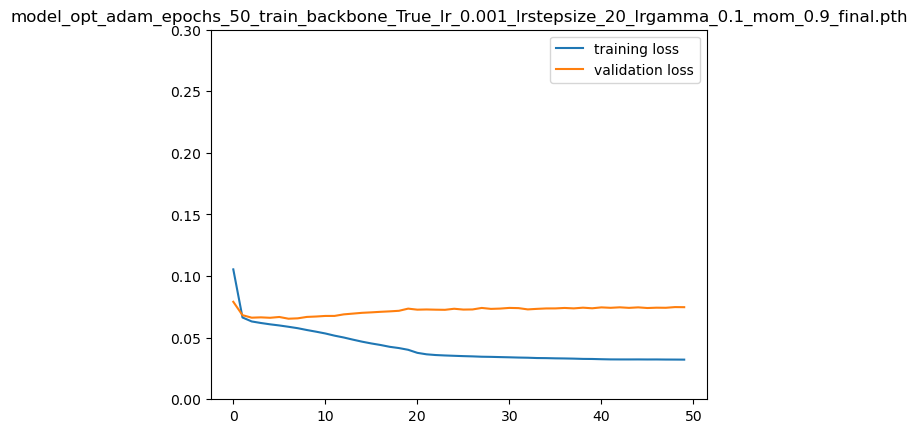

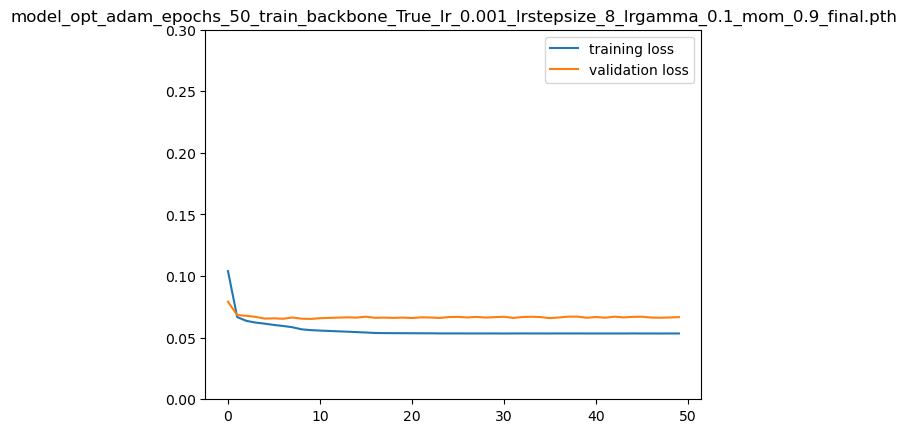

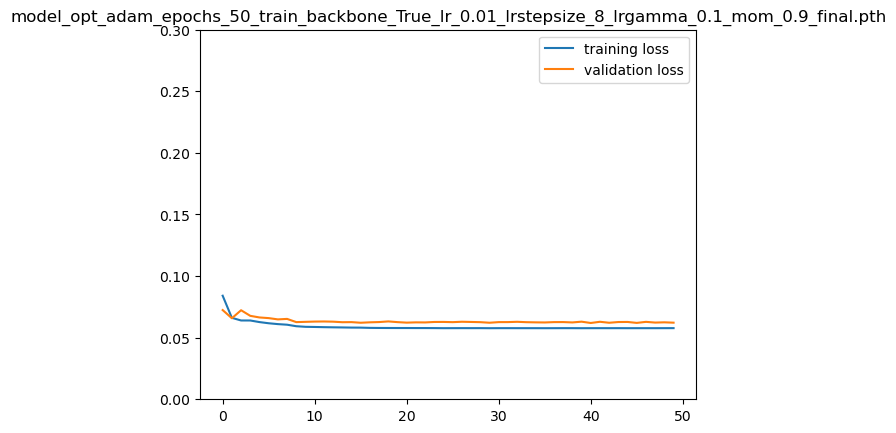

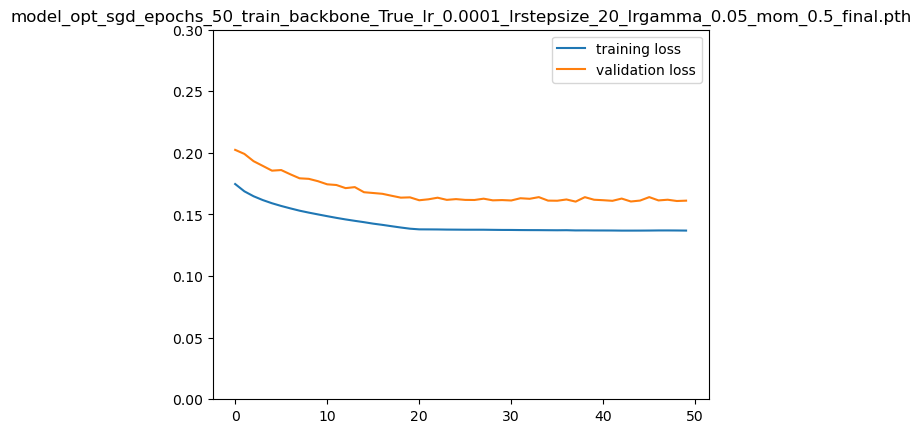

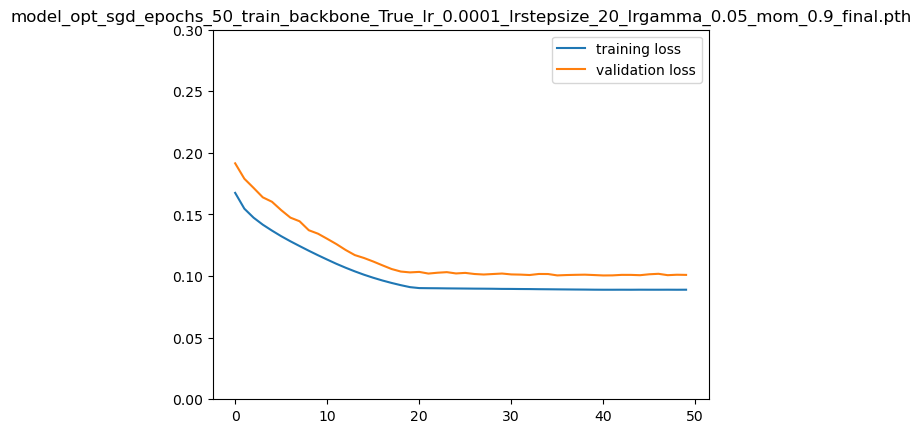

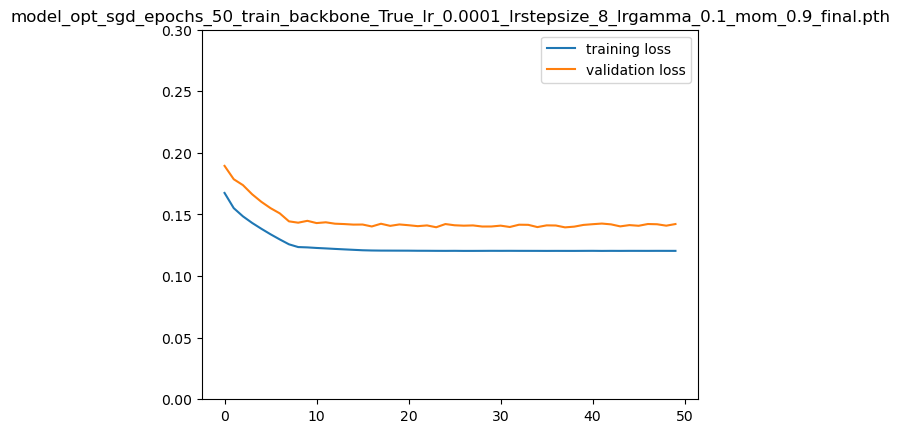

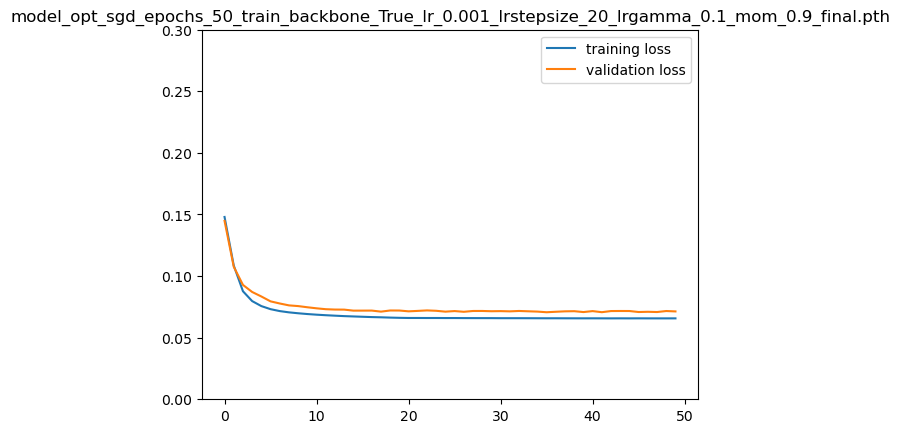

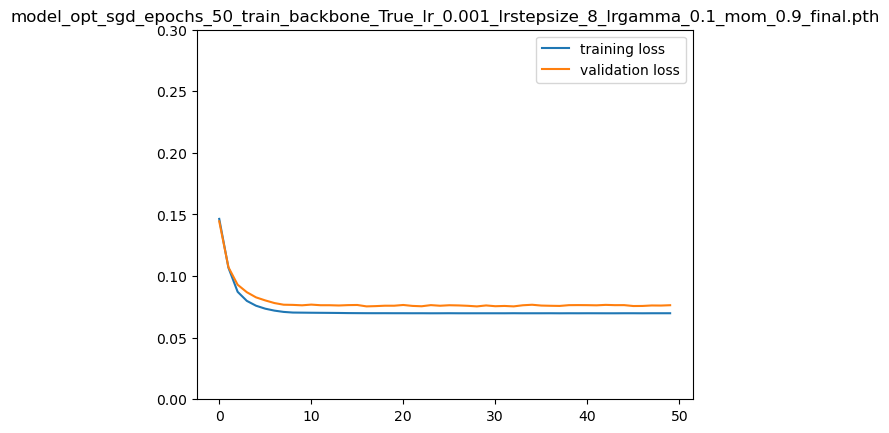

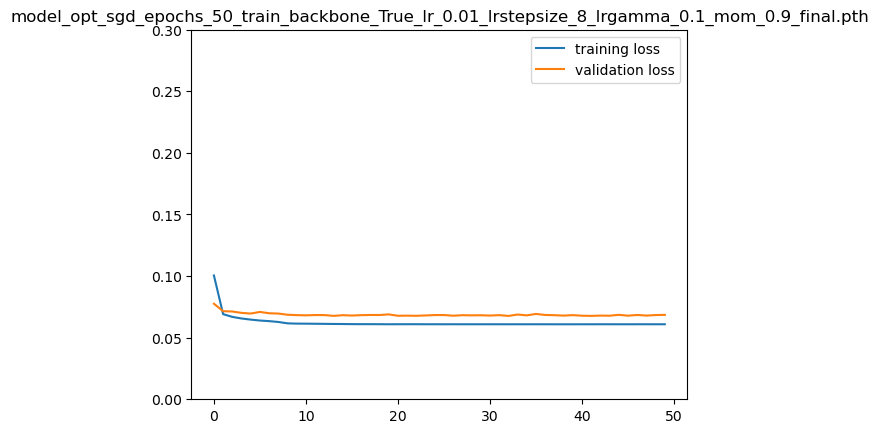

In [4]:
import matplotlib.pyplot as plt

model = ssdlite320_mobilenet_v3_large(weights=None, num_classes=3, weights_backbone=None) # we do not specify pretrained=True, i.e. do not load default weights

modelsFolder = "Results/Models"

for modelFile in os.listdir(modelsFolder):
    path = os.path.join(modelsFolder, modelFile)
    checkpoint = torch.load(path)

    #model.load_state_dict(checkpoint['model'])

    plt.plot(checkpoint["losses_train"], label="training loss")
    plt.plot(checkpoint["losses_val"], label="validation loss")
    plt.title(modelFile)
    plt.legend()
    plt.ylim((0, 0.3))
    plt.show()

In [5]:
from torch.utils.data import DataLoader
from src.dataLoading import playersDataset, collate_fn   # these are custom for our dataset




num_workers = 1 if torch.cuda.is_available() else 0
batch_size = 8 # LOWER THIS IF NEEDED!

train_dir = "Data/train/"
valid_dir = "Data/valid/"
test_dir = "Data/valid/"
train_dataset = playersDataset(train_dir)
validation_dataset = playersDataset(valid_dir)
test_dataset = playersDataset(test_dir)

# Define the dataloaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [11]:
from Evaluation.engine import evaluate


evaluate(model=model, data_loader=test_loader, device=device)

creating index...
index created!
Test:  [ 0/56]  eta: 0:00:10  model_time: 0.1220 (0.1220)  evaluator_time: 0.0334 (0.0334)  time: 0.1884  data: 0.0300  max mem: 951
Test:  [55/56]  eta: 0:00:00  model_time: 0.1135 (0.1172)  evaluator_time: 0.0257 (0.0252)  time: 0.1716  data: 0.0295  max mem: 951
Test: Total time: 0:00:09 (0.1770 s / it)
Averaged stats: model_time: 0.1135 (0.1172)  evaluator_time: 0.0257 (0.0252)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.

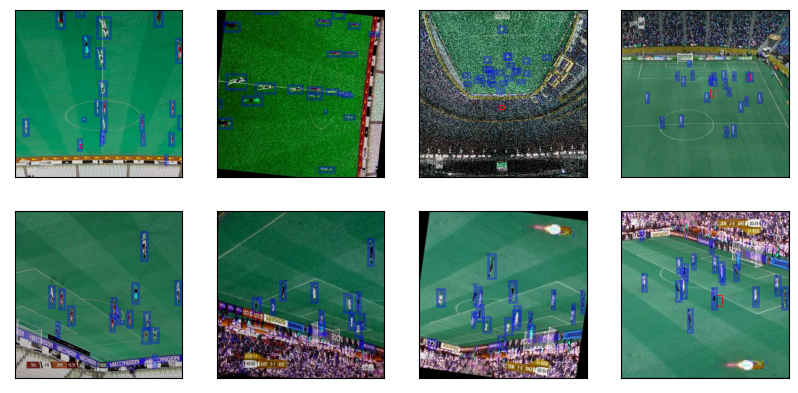

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Colours = ['r','g','b']

def visualize_imgs(imgs, annotations, true_annotations, rows, cols, threshold, tensors=False):
    CLASSES = ["","ball", "player"]
    fig = plt.figure(figsize=(10,10))
    
    for i in range(len(imgs)):
        ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])

        boxes = annotations[i]['boxes']
        true_boxes = true_annotations[i]['boxes']
        labels = annotations[i]['labels']
        scores = annotations[i]['scores']
        
        img = None



        if(tensors):
            img = imgs[i].cpu().numpy().transpose(1, 2, 0)
        else:
            img = imgs[i].numpy().transpose(1, 2, 0)
        ax.imshow(img, origin='upper')

        for j, (box, score, label) in enumerate(zip(boxes, scores,labels)):
            if(score < threshold):
                continue
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='r', facecolor='none', linewidth=0.5)
            ax.add_patch(rect)

            #ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')
        
        for j, box in enumerate(true_boxes):
            top, left = int(box[0]), int(box[1])
            width = int(box[2] - box[0])
            height = int(box[3] - box[1])

            #top, left, width, height = [448*i for i in boxes[i][0:]]
            rect = patches.Rectangle((top, left), width, height, edgecolor='b', alpha=0.3, facecolor='none', linewidth=2.0)
            ax.add_patch(rect)

            # ax.text(top, left, CLASSES[int(labels[j])], horizontalalignment='left', verticalalignment='bottom', color='white', weight='bold')

    plt.show()


model.eval()
images, targets = next(iter(train_loader))
images = list(image.to(device) for image in images)
preds = model(images)

threshold = 0.2

fig = visualize_imgs(images, preds, targets, rows=4, cols=4, threshold = threshold, tensors=True)